## MaxCut Problem

The **MaxCut problem** is a combinatorial optimization problem where the goal is to partition the vertices of a graph into two disjoint subsets such that the number (or weight) of edges between the subsets is maximized.

### Definition:
Given:
- A graph \( G = (V, E) \) where \( V \) is the set of vertices and \( E \) is the set of edges,
- Each edge $( (u, v) \in E )$ may have a weight $( w_{uv} )$,

The objective is to find a partition \( (S, T) \) of \( V \) such that the sum of weights of edges crossing between \( S \) and \( T \) is maximized.

The MaxCut problem is **NP-hard**, meaning there is no known polynomial-time solution for all cases, but approximation algorithms and quantum approaches (e.g., QAOA) can be used to find near-optimal solutions efficiently.


## References
[1] Solve utility-scale quantum optimization problems:  
[qiskit QAOA](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)\
[2] MaxCut by BallBoii:  
[Maxcut_tutorial.ipynb](https://github.com/BallBoii/Maxcut_Tutorial/blob/main/Maxcut_tutorial.ipynb)



## Unweighted MaxCut

matrix([[0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0.]])

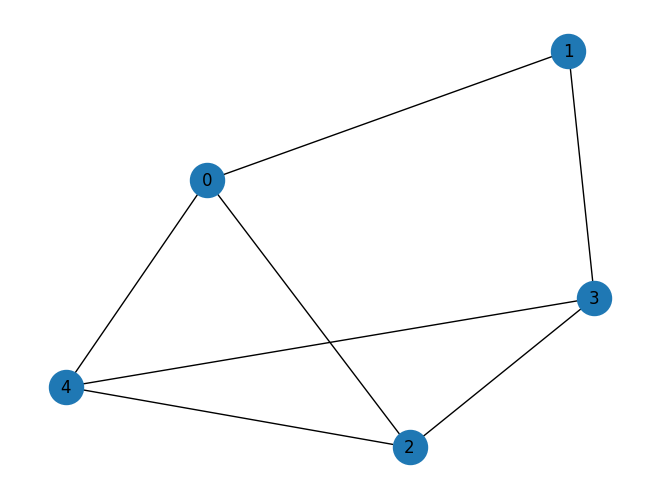

In [1]:
from maxcut import MaxCut

maxcut = MaxCut(5, 125)
maxcut.weight_matrix

In [2]:
qubo = maxcut.qubo()
cost_hamiltonian, offset = qubo['model'], qubo['offset']
print(f"====Cost Hamiltonian directly====")
print(maxcut.build_max_cut_paulis(), '\n')
print(f"====Cost Hamiltonian from qubo====")
print(cost_hamiltonian, f"{offset=}", sep='\n')

====Cost Hamiltonian directly====
SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IZIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]) 

====Cost Hamiltonian from qubo====
SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IZIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
offset=np.float64(-3.5)


## Solve locally

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2])])


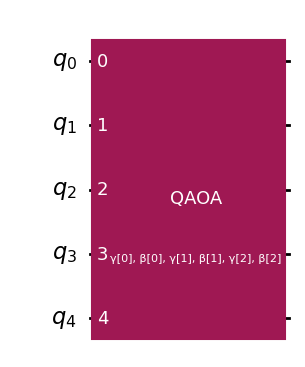

In [3]:
from qiskit.circuit.library import QAOAAnsatz

reps = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
print(circuit.parameters)
circuit.draw('mpl')

In [4]:
from utils import QAOA
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

qaoa = QAOA(reps=reps)

estimator = Estimator()

result = minimize(
    qaoa.cost_func_estimator,
    qaoa.init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.5307585471857836
       x: [ 4.773e+00  1.809e+00  2.855e+00  2.517e+00  3.107e+00
            1.450e+00]
    nfev: 74
   maxcv: 0.0


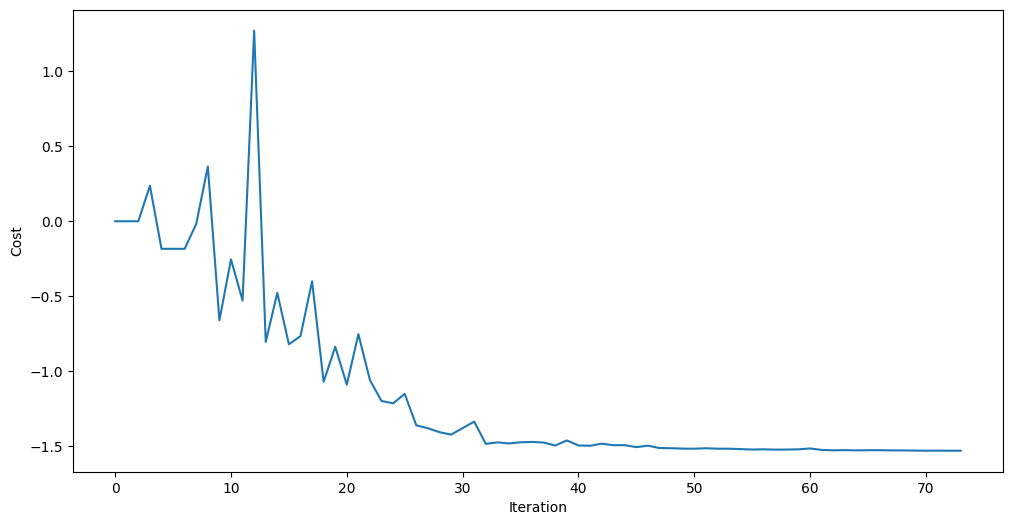

-5.030758547185783


In [5]:
cost = qaoa.draw_cost_function()
print(cost + offset)

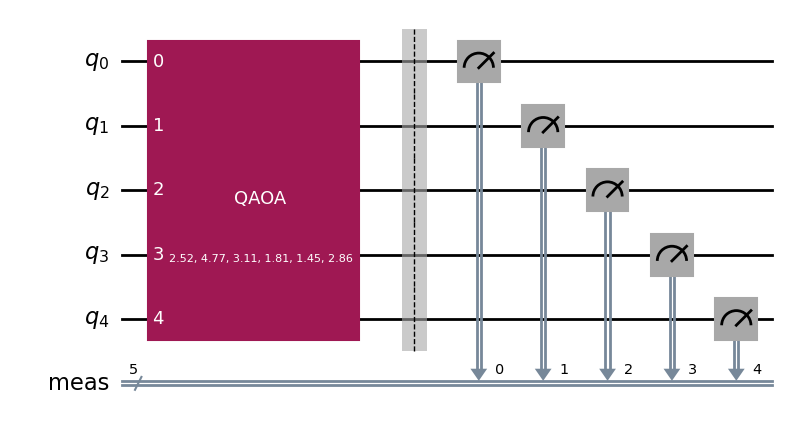

In [6]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [7]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(default_shots=10000)
# sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{4: 0.0143, 24: 0.0232, 13: 0.0727, 16: 0.0159, 9: 0.2179, 25: 0.0697, 15: 0.0144, 18: 0.0694, 22: 0.2182, 17: 0.0237, 6: 0.0691, 5: 0.0225, 27: 0.0124, 7: 0.0245, 19: 0.0196, 21: 0.0039, 0: 0.0028, 8: 0.0019, 10: 0.0064, 26: 0.0236, 14: 0.0249, 3: 0.0054, 29: 0.0017, 20: 0.003, 11: 0.0046, 12: 0.0222, 2: 0.0011, 28: 0.0039, 31: 0.0033, 23: 0.0012, 1: 0.001, 30: 0.0016}


In [8]:
from utils import to_bitstring
import numpy as np

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(maxcut.graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1]


C:\Users\natsg\AppData\Local\Temp\ipykernel_7064\3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


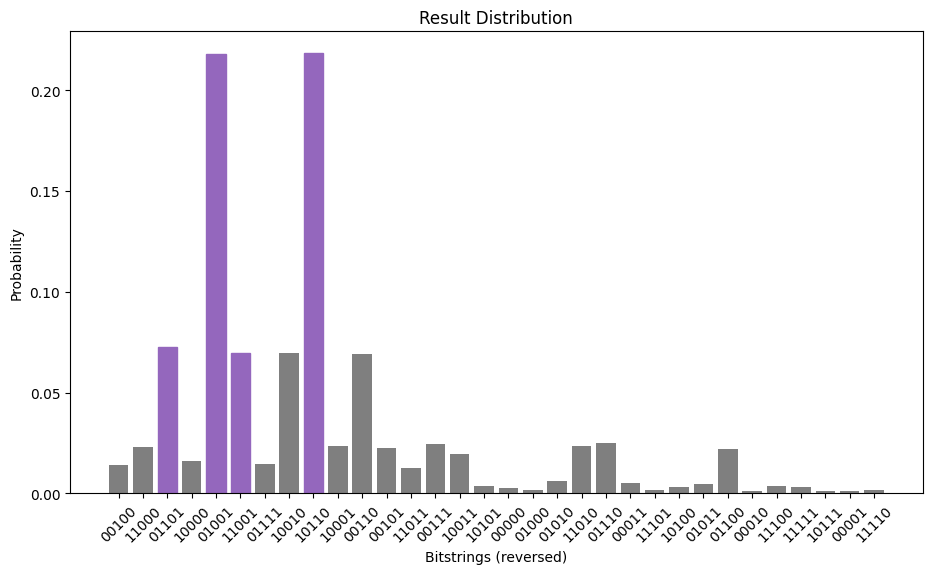

In [9]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

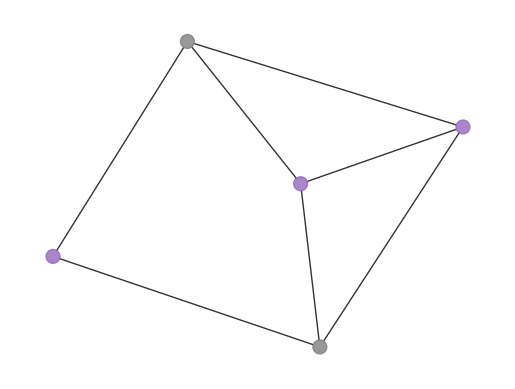

In [10]:
import rustworkx as rx
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(maxcut.graph, most_likely_bitstring)

In [11]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, maxcut.graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 6
